# Inversion of a sphere based on gravity response

This is a simple example for the probabilistic inversion of a classical geophysical example: the inversion of a sphere in the subsurface with a different density to the environment based on observed gravity data.

We start with the simplest possible case of only one observation (directly above the sphere) and only depth as an uncertain variable and then make the model progressively more complex.

In [23]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')

## Geometric model

We consider here a sphere in the subsurface with a different density. 

<div class="alert alert-danger">
    <b>Note</b>: check with Jorge: is this the equation for a sphere or for a (2-D) circular object, i.e. a cylinder in 2.5-D, with lateral (infinite) extension?</div>



In [24]:
# e=300 # What was this variable meant for??
sphere_center = 300 #m 
sphere_radius = 100 #m
density_difference = 500 # kg/m^3: density diffrence to surrounding domain

x_domain=np.linspace(-1000,1000,101) #m

Let's create a plot for a visual representation of this model:

Text(0, 0.5, 'Y [m]')

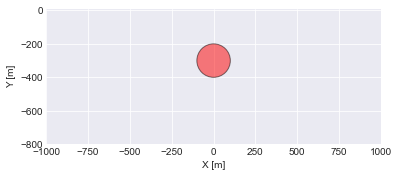

In [25]:
ax = plt.subplot(aspect='equal') 

# create circle object as matplotlib patch
circle1 = plt.Circle((0, -sphere_center), sphere_radius, 
                     facecolor='r', edgecolor='k', alpha=0.5)

ax.add_artist(circle1)

# set model domain
ax.set_xlim([-1000,1000])
ax.set_ylim([-800,10])

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")

# fig.savefig('grav_domain.png')

We now calculate the effect of this density contrast that would be observed on the surface. This is a well-studied example with an analytical solution:

$$g(x) = 10^5 \;\frac{4}{3} \,\pi \;\frac{r^3 \,\Delta \rho\, G\, z}
{\sqrt{\left( x^2 + z^2\right)^3}}$$

where:

- $z$ is the vertical position of the center of the sphere (lateral position at origin),
- $r$ its radius,
- $\Delta \rho$ the density difference to the surrounding domain,
- $G$ the gravitational constant,
- and $x$ the position at which the gravitational acceleration is calculated.

<div class="alert alert-warning">
    <b>Jorge</b>: reference for this equation?</div>




In [26]:
def grav_analytical(x, sphere_center, sphere_radius, density_difference):
    """Calculate gravitational effect of a sphere, measured at surface
    
    **Arguments**:
    - 'x' = scalar or np.array: position(s) of observation
    - 'sphere_center' = float: is the vertical position of the center of the sphere (lateral position at origin)
    - 'sphere_radius' = float: sphere radius
    - 'density_difference' = float: density difference to the surrounding domain
    """
    G=6.67e-11 # gravitational constant
    return ((4/3)*np.pi * (sphere_radius**3) * density_difference
            * G * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5


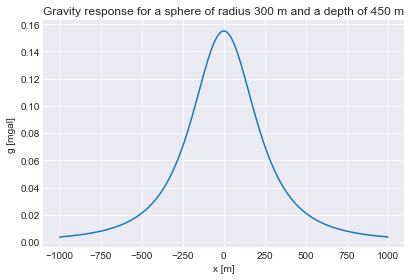

In [27]:
grav_all = grav_analytical(x_domain, sphere_center, sphere_radius, density_difference)
plt.plot(x_domain, grav_all, '-')
plt.xlabel("x [m]")
plt.ylabel("g [mgal]")
plt.title("Gravity response for a sphere of radius 300 m and a depth of 450 m");
plt.tight_layout()

## Create synthetic data set

We now "generate" our synthetic data set (note here: a beautiful case of the "zero order inverse crime" - but also a common approach to generate the synthetic data set with the same method that we later use to perform inference... but: beware the limitations!)

And for even more simplification, let's only look at the value at x = 0.

In [28]:
grav_obs = grav_analytical(0, sphere_center, sphere_radius, density_difference)
grav_obs

0.15521794814402903

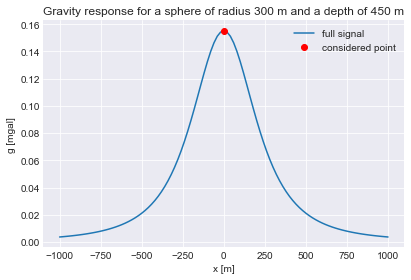

In [29]:
plt.plot(x_domain, grav_all, '-', label="full signal")
plt.plot(0, grav_obs, 'ro', label='considered point')
plt.xlabel("x [m]")
plt.ylabel("g [mgal]")
plt.title("Gravity response for a sphere of radius 300 m and a depth of 450 m");
plt.legend()
plt.tight_layout()

## Set up probablistic model

We now define the probabilistic model using `pymc3`. We will also use `scipy.stats` to plot the distributions (_Note: could probably also be done with pymc..._):

In [30]:
import pymc3 as pm
from scipy.stats import norm

### First simple test: consider depth only

As a first test, we only consider the depth of the sphere as uncertain (varible z). For simplicity, we start with a normal distribution as a prior for this parameter:

$$Z = \mathcal{N}(\mu, \sigma)$$

Let's sart with an (arbitrary) definition for our prior guess and standard deviation.

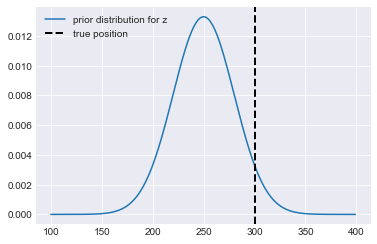

In [62]:
# set mean and std. for prior guess:

mean_z = 250
std_z = 30

xvals=np.arange(100,400)

normal_dist=norm.pdf(xvals, mean_z, std_z)

plt.plot(xvals, normal_dist,'-', label='prior distribution for z')
plt.axvline(300, label="true position", color='k', 
            linestyle='--', linewidth=2)
# plt.hist(vals, 100, density=True);
plt.legend();


## Next step: define likelihood function!

A likelihood fucntion gves an idea of how the data summarizes these parameters

$$p\left(\theta | y \right) \approx {p\left( y | \theta \right)} \, p(\theta)$$

So, we now need to define the likelihood function. Recall: it is a function of the parameter $\theta$, but we need to inlcude the observed values $y$ into the calculation. 

We will also use here a normal distribution for the likelihood function - a reasonable assumption assuming typical measurement errors.

In `pymc`, we use a similar formulation like for the stochastic variable/ model parameter, but the definition to be a likelihood function is set by providing the observed value(s) using `observed = grav_obs`.



In [63]:
with pm.Model() as model: 
    # define prior for z:
    Z = pm.Normal("z", mean_z, std_z)
    
    # calculate the forward model/ gravity effect at position 0:
    # (techincal note: pm.Deterministic() required to store results of 
    # forward model for later inspection!)
    grav_calc = pm.Deterministic("grav_fwd", grav_analytical(0, Z,
                                sphere_radius, density_difference))

    # define the likelihood function
    y = pm.Normal("y", grav_calc, .01, observed=grav_obs)
    traces = pm.sample(1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 5759.34draws/s]


###  Compare results

Prior $p(\theta)$ vs. posterior $p(\theta | y)$:

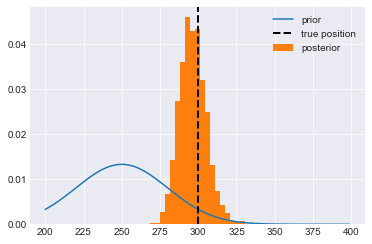

In [64]:
from scipy.stats import norm

xvals=np.arange(200,400)
normal_dist=norm.pdf(xvals, mean_z, std_z)

plt.plot(xvals, normal_dist,'-', label='prior')
plt.hist(traces.z, 20, 
         density=True, label='posterior');
plt.axvline(300, label="true position", color='k', 
            linestyle='--', linewidth=2)
plt.legend();

This result looks quite promising so far - we are able to obtain the "correct" depth position of the sphere, even though our prior guess is quite off.

Here a function for a more visual interpretation of the results:


In [65]:
def plot_posterior_models(traces, n_thin=10, show_solution=True):
    """Create visualization of posterior models
    
    **Arguments**:
    - traces = pymc.traces object with posterior samples
    - n_thin = int : thinning of trace results
    - show_solution = bool : show "true" model
    """

    ax = plt.subplot(aspect='equal') 
    
    # plot solution
    if show_solution:
        circle1 = plt.Circle((0, -sphere_center), 
                                 sphere_radius, 
                                 facecolor='white', alpha=1,
                                 edgecolor='gray')
        ax.add_artist(circle1)
    
    # determine if radius in traces (i.e. uncertain) or not:
    if 'r' in traces.varnames:
        # create multiple circles based on every n-th value stored in traces:
        for i in range(int(len(traces)/n_thin)):
            circle1 = plt.Circle((0, -traces.z[int(i*n_thin)]), 
                                 traces.r[int(i*n_thin)], 
                                 facecolor='r', alpha=0.01)#,
                                #edgecolor='gray')
            ax.add_artist(circle1)
    else:
        # create multiple circles based on every n-th value stored in traces:
        for i in range(int(len(traces)/n_thin)):
            circle1 = plt.Circle((0, -traces.z[int(i*n_thin)]), 
                                 sphere_radius, 
                                 facecolor='r', alpha=0.01)#,
                                #edgecolor='gray')
            ax.add_artist(circle1)

    


    # set model domain
    ax.set_xlim([-250,250])
    ax.set_ylim([-500,10])

    ax.set_xlabel("X [m]")
    ax.set_ylabel("Z [m]")
    
    plt.title("Model realizaions (posterior predictive)")



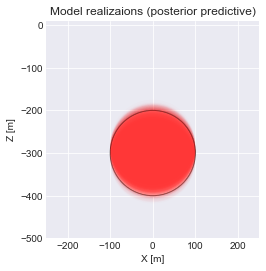

In [66]:
plot_posterior_models(traces)

We can see that our estimates are quite accurate. Try experimenting with the distributions (and prior guess) above to see how this can change.

### More methods to inspect the inference results

There are a whole range of methods to investigate the results of your sampling - and this will especially become important when the results are not anymore so ideal and easy to interpret as we observe here.

`pymc` provides several of these methods. For a start, here some simple implemented methods to plot traces and samples from the posterior - as well as the results of the forward models:

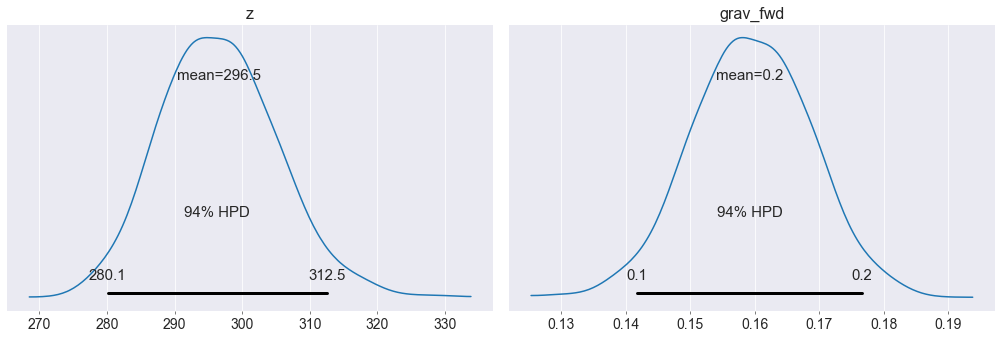

In [67]:
pm.plot_posterior(traces);

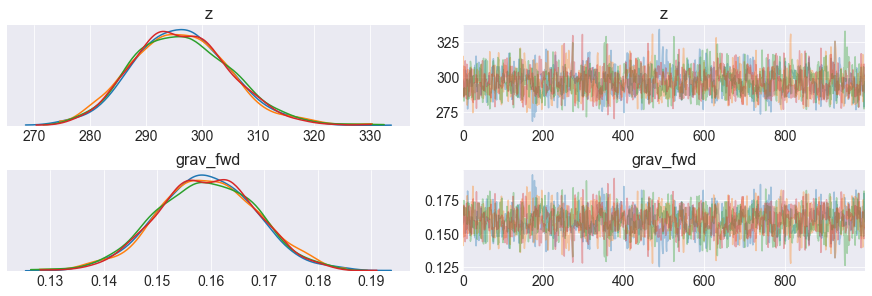

In [68]:
pm.traceplot(traces);

### Prior predictive checks

As a side note: it is also often a good idea to inspect the so-called prior predictive distribution. Recall: Betancourt (blog) about principled bayesian workflows (https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html);

Also mentioned in the scipy conference video!

The idea:

- take samples from prior distribution
- pass through generative (forward) model
- check and compare to observed data

This step is really easy in `pymc3`:

In [69]:
with model:
    prior = pm.sample_prior_predictive(10000)

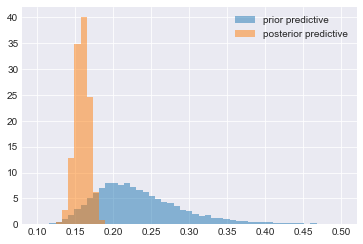

In [70]:
bins = np.linspace(0.1,0.5)
plt.hist(prior['grav_fwd'], bins, density=True, 
         alpha=0.5, label='prior predictive')
plt.hist(traces['grav_fwd'], bins, density=True, 
         alpha=0.5, label='posterior predictive');
plt.legend();

## Making the model more complex

However, to be sure, this is a highly simplified and idealized model - and we only used one data point so far. So, as the next steps:

1. Adding more data points to infernce
2. Adding more model parameters as uncertain (first radius, then also density)

### Adding observations

We use again the "ideal" analytical gravity calculation to obtain more synthetic observations - but we will also add an additional option to inlcude noise:

In [40]:
x_obs = np.linspace(-250, 250, 11)
grav_obs_array = grav_analytical(x_obs, sphere_center, sphere_radius, density_difference)


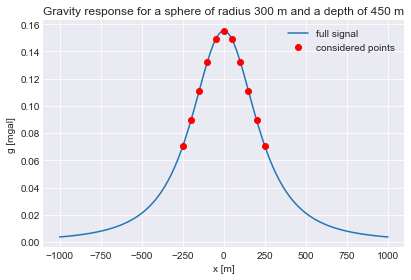

In [41]:
plt.plot(x_domain, grav_all, '-', label="full signal")
plt.plot(x_obs, grav_obs_array, 'ro', label='considered points')
plt.xlabel("x [m]")
plt.ylabel("g [mgal]")
plt.title("Gravity response for a sphere of radius 300 m and a depth of 450 m");
plt.legend()
plt.tight_layout()

We now only need to change two lines in our model:

- the gravity forward calculation, in which we now have to pass `x_obs`, instead of `0`, and
- the likleihood function, in which we have to pass now `observed=grav_obs_array`:

In [42]:
with pm.Model() as model: 
    # define prior for z:
    Z = pm.Normal("z", mean_z, std_z)
    
    # calculate the forward model/ gravity effect at position 0:
    # (techincal note: pm.Deterministic() required to store results of 
    # forward model for later inspection!)
    grav_calc = pm.Deterministic("grav_fwd", grav_analytical(x_obs, Z,
                                sphere_radius, density_difference))

    # define the likelihood function
    y = pm.Normal("y", grav_calc, .01, observed=grav_obs_array)
    traces = pm.sample(1000)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4859.65draws/s]
The acceptance probability does not match the target. It is 0.8903858341302577, but should be close to 0.8. Try to increase the number of tuning steps.


Let's have a look at the results:

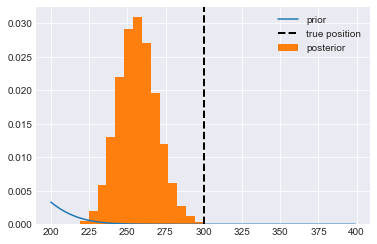

In [61]:
xvals=np.arange(200,400)
normal_dist=norm.pdf(xvals, mean_z, std_z)

plt.plot(xvals, normal_dist,'-', label='prior')
plt.hist(traces.z, 20, 
         density=True, label='posterior');
plt.axvline(300, label="true position", color='k', 
            linestyle='--', linewidth=2)
plt.legend();

Interesting observation: the fit is now better than before (ok, to be expected with more data... but still interesting, given that this is such a simple model).

### Adding noise to obeservations

Let's see what happens if we now add noise to our observations (note: the noise level should also be reflected in the noise assigned to the standard deviation):


In [78]:
# grav_obs_array_noise = grav_obs_array + norm(0,0.01).rvs(len(grav_obs_array))

grav_obs_array_noise = np.array([0.05903379, 0.09325413, 0.12603046, 0.12897358, 0.1410927 ,
       0.15062356, 0.14837635, 0.12898567, 0.10370969, 0.07757154,
       0.07276111])

In [79]:
grav_obs_array_noise

array([0.05903379, 0.09325413, 0.12603046, 0.12897358, 0.1410927 ,
       0.15062356, 0.14837635, 0.12898567, 0.10370969, 0.07757154,
       0.07276111])

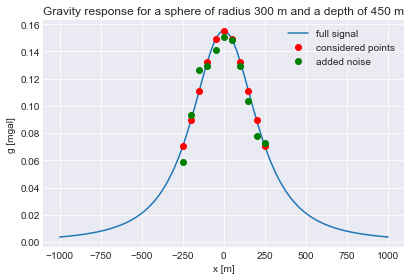

In [80]:
plt.plot(x_domain, grav_all, '-', label="full signal")
plt.plot(x_obs, grav_obs_array, 'ro', label='considered points')
plt.plot(x_obs, grav_obs_array_noise, 'go', label='added noise')
plt.xlabel("x [m]")
plt.ylabel("g [mgal]")
plt.title("Gravity response for a sphere of radius 300 m and a depth of 450 m");
plt.legend()
plt.tight_layout()

In [81]:
with pm.Model() as model_noise: 
    # define prior for z:
    Z = pm.Normal("z", mean_z, std_z)
    
    # calculate the forward model/ gravity effect at position 0:
    # (techincal note: pm.Deterministic() required to store results of 
    # forward model for later inspection!)
    grav_calc = pm.Deterministic("grav_fwd", grav_analytical(x_obs, Z,
                                sphere_radius, density_difference))

    # define the likelihood function
    y = pm.Normal("y", grav_calc, .01, observed=grav_obs_array_noise)
    traces = pm.sample(1000)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 5589.85draws/s]
The acceptance probability does not match the target. It is 0.8839490371823645, but should be close to 0.8. Try to increase the number of tuning steps.


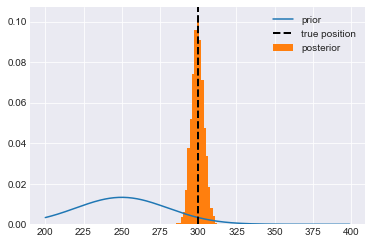

In [82]:
plt.plot(xvals, normal_dist,'-', label='prior')
plt.hist(traces.z, 20, 
         density=True, label='posterior');
plt.axvline(300, label="true position", color='k', 
            linestyle='--', linewidth=2)
plt.legend();

Also interesting now to inspect the trace plots (note that we now also nicely get results for the multiple positions):

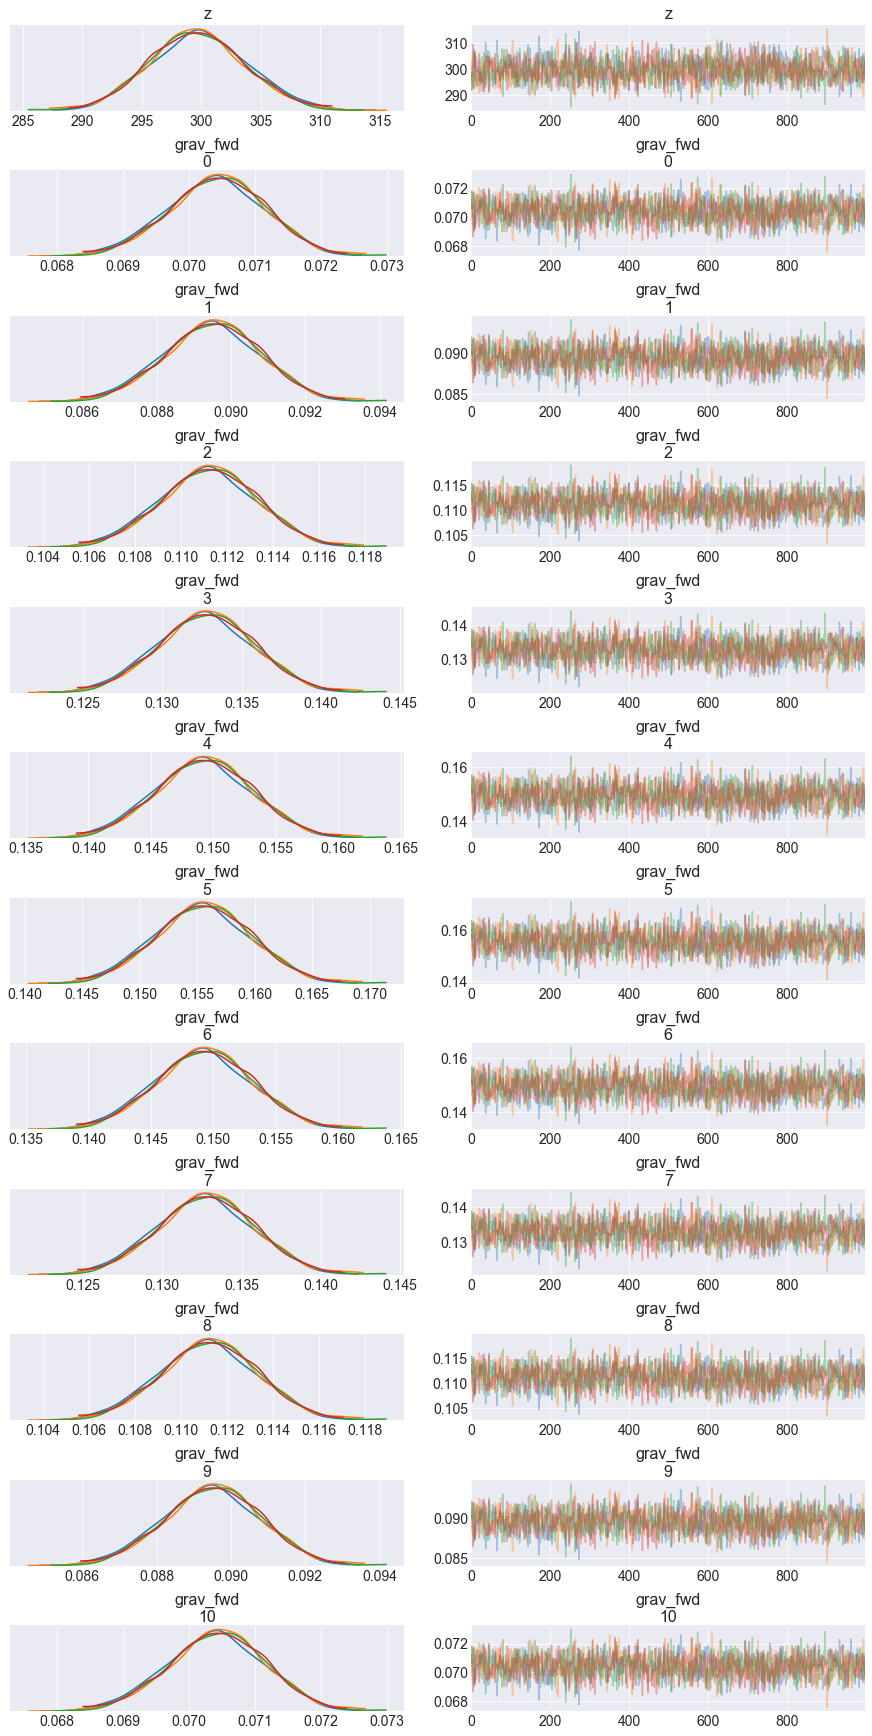

In [83]:
pm.traceplot(traces);

### Adding radius as uncertain parameter

So, now it's finally time to make our model more complex! As a next step, let's add the radius of the sphere. Also, we will define here a normal distribution to parameterise the radius and define a simple prior guess.

(**Note**: a better choice would be a non-negative distribution - adjust later)

We can directly add it into our model:

In [49]:
mean_r = 50.
std_r = 10.

with pm.Model() as model_ext: 
    # define prior for z:
    Z = pm.Normal("z", mean_z, std_z)
    R = pm.Normal("r", mean_r, std_r)
    
    # calculate the forward model/ gravity effect at position 0:
    # (techincal note: pm.Deterministic() required to store results of 
    # forward model for later inspection!)
    grav_calc = pm.Deterministic("grav_fwd", grav_analytical(x_obs, Z,
                                R, density_difference))

    # define the likelihood function
    y = pm.Normal("y", grav_calc, .01, observed=grav_obs_array_noise)
    traces = pm.sample(10000)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r, z]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:14<00:00, 2965.44draws/s]
The acceptance probability does not match the target. It is 0.882204977503164, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


So, with this additional uncertainty, we expect of course our results to be worse. Let's investigate the posterior distributions:

Text(0.5, 1.0, 'radius')

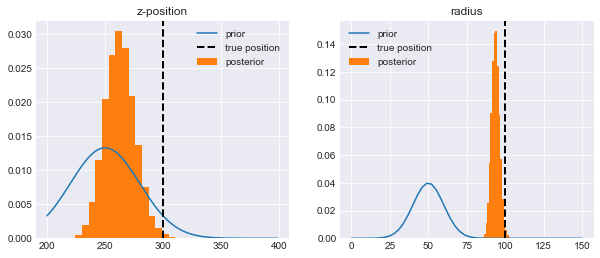

In [50]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].plot(xvals, normal_dist,'-', label='prior')
ax[0].hist(traces.z, 20, 
         density=True, label='posterior');
ax[0].axvline(300, label="true position", color='k', 
            linestyle='--', linewidth=2)
ax[0].legend();
ax[0].set_title("z-position")

rvals = np.linspace(0,150)
ax[1].plot(rvals, norm(mean_r, std_r).pdf(rvals),'-', label='prior')
ax[1].hist(traces.r, 20, 
         density=True, label='posterior');
ax[1].axvline(100, label="true position", color='k', 
            linestyle='--', linewidth=2)
ax[1].legend();
ax[1].set_title("radius")

Actually, still quite good. Let's see what it looks like in our model representation:

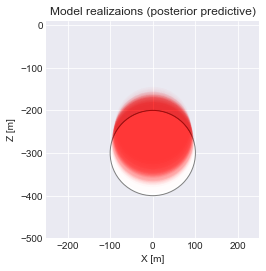

In [51]:
plot_posterior_models(traces, n_thin=100)

We start to see the effect of the uncertain radius - and it also seems to be the case that the radius uncertainty is incresing with depth. Of course, this is to be expected from the forward model (right?).

So, let's have a look at the posterior draws for depth and radius of the sphere:

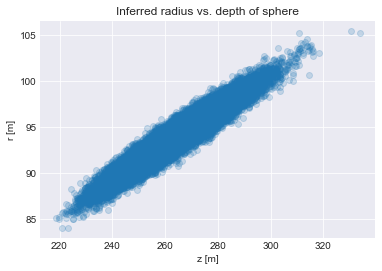

In [52]:
plt.scatter(traces.z, traces.r, alpha=0.2)
plt.xlabel("z [m]")
plt.ylabel("r [m]")
plt.title("Inferred radius vs. depth of sphere");

We see a clear correlation between these two variables in the posterior distribution (note that they were independent before - check model above).

### Adding density difference as uncertain parameter

As a final step, let's also add the density value itself as an uncertain parameter. Again, we consider a normal distribution and add it to the model:

In [88]:
# Recall: correct positions:
# sphere_center = 300 #m 
# sphere_radius = 100 #m
# density_difference = 500 # kg/m^3: density diffrence to surrounding domain

mean_r = 80.
std_r = 10.
mean_d = 480
std_d = 10
mean_z = 280
std_z = 10

with pm.Model() as model_ext: 
    # define prior for z:
    Z = pm.Normal("z", mean_z, std_z)
    R = pm.Normal("r", mean_r, std_r)
    Drho = pm.Normal("d_rho", mean_d, std_d)
    
    # calculate the forward model/ gravity effect at position 0:
    # (techincal note: pm.Deterministic() required to store results of 
    # forward model for later inspection!)
    grav_calc = pm.Deterministic("grav_fwd", grav_analytical(x_obs, Z,
                                R, Drho))

    # define the likelihood function
    y = pm.Normal("y", grav_calc, .01, observed=grav_obs_array_noise)
    traces = pm.sample(1000)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d_rho, r, z]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2579.91draws/s]


Text(0.5, 1.0, 'density')

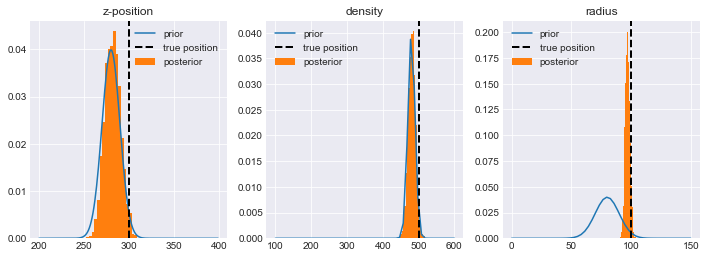

In [90]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

normal_dist=norm.pdf(xvals, mean_z, std_z)

ax[0].plot(xvals, normal_dist,'-', label='prior')
ax[0].hist(traces.z, 20, 
         density=True, label='posterior');
ax[0].axvline(300, label="true position", color='k', 
            linestyle='--', linewidth=2)
ax[0].legend();
ax[0].set_title("z-position")

rvals = np.linspace(0,150)
ax[2].plot(rvals, norm(mean_r, std_r).pdf(rvals),'-', label='prior')
ax[2].hist(traces.r, 20, 
         density=True, label='posterior');
ax[2].axvline(100, label="true position", color='k', 
            linestyle='--', linewidth=2)
ax[2].legend();
ax[2].set_title("radius")

dvals = np.linspace(100,600)
ax[1].plot(dvals, norm(mean_d, std_d).pdf(dvals),'-', label='prior')
ax[1].hist(traces.d_rho, 20, 
         density=True, label='posterior');
ax[1].axvline(500, label="true position", color='k', 
            linestyle='--', linewidth=2)
ax[1].legend();
ax[1].set_title("density")

The inferred values do get a bit worse, especially the vertical position is now quite a bit off (influenced by the strong prior, of course). Here also the representation in the model view:

In [91]:
# Recall: correct positions:
# sphere_center = 300 #m 
# sphere_radius = 100 #m
# density_difference = 500 # kg/m^3: density diffrence to surrounding domain

mean_r = 80.
std_r = 10.
mean_d = 480
std_d = 10
mean_z = 280
std_z = 10

with pm.Model() as model_ext: 
    # define prior for z:
    Z = pm.Normal("z", mean_z, std_z)
    R = pm.Normal("r", mean_r, std_r)
    Drho = pm.Normal("d_rho", mean_d, std_d)
    
    # calculate the forward model/ gravity effect at position 0:
    # (techincal note: pm.Deterministic() required to store results of 
    # forward model for later inspection!)
    grav_calc = pm.Deterministic("grav_fwd", grav_analytical(x_obs, Z,
                                R, Drho))

    # define the likelihood function
    y = pm.Normal("y", grav_calc, .01, observed=grav_obs_array_noise)
    step = pm.Metropolis()
    traces = pm.sample(1000,step)



Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [d_rho]
>Metropolis: [r]
>Metropolis: [z]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:00<00:00, 6221.55draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Text(0.5, 1.0, 'density')

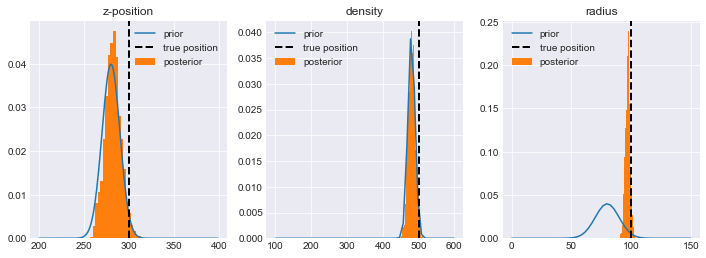

In [92]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

normal_dist=norm.pdf(xvals, mean_z, std_z)

ax[0].plot(xvals, normal_dist,'-', label='prior')
ax[0].hist(traces.z, 20, 
         density=True, label='posterior');
ax[0].axvline(300, label="true position", color='k', 
            linestyle='--', linewidth=2)
ax[0].legend();
ax[0].set_title("z-position")

rvals = np.linspace(0,150)
ax[2].plot(rvals, norm(mean_r, std_r).pdf(rvals),'-', label='prior')
ax[2].hist(traces.r, 20, 
         density=True, label='posterior');
ax[2].axvline(100, label="true position", color='k', 
            linestyle='--', linewidth=2)
ax[2].legend();
ax[2].set_title("radius")

dvals = np.linspace(100,600)
ax[1].plot(dvals, norm(mean_d, std_d).pdf(dvals),'-', label='prior')
ax[1].hist(traces.d_rho, 20, 
         density=True, label='posterior');
ax[1].axvline(500, label="true position", color='k', 
            linestyle='--', linewidth=2)
ax[1].legend();
ax[1].set_title("density")

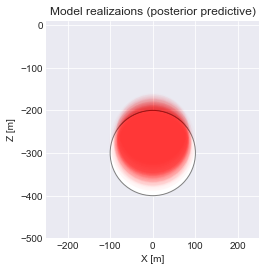

In [91]:
plot_posterior_models(traces, n_thin=100)

## To do

This model hopefully gave a bit of an insight into how to set up (simple) models using `pymc3` - on the basis of the (very simple) gravity model.

For more insight, play around with the parameters:

- change the prior distributions, especially try different values for standard deviations;
- try adding or removing observation points;
- change noise level;
- ...



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c282cb828>,
      dtype=object)

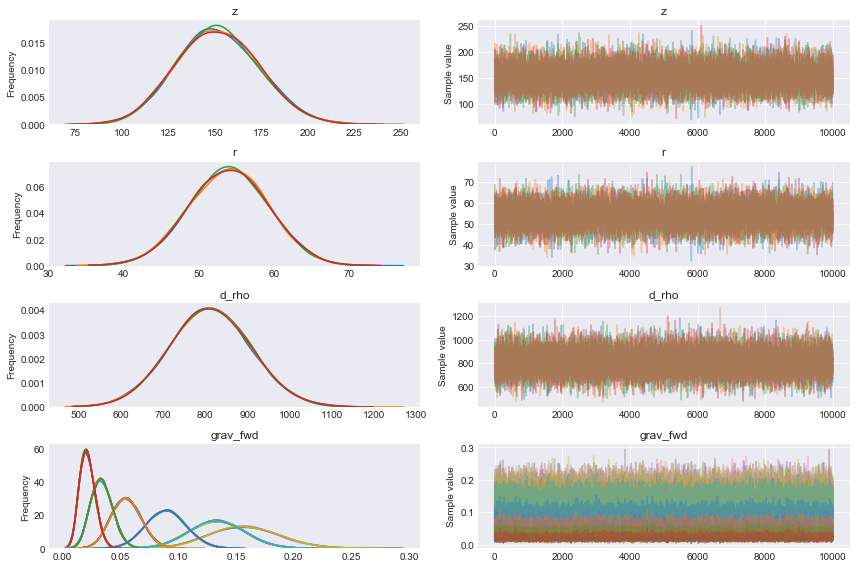

In [53]:
pm.traceplot(traces);